In [29]:
import gym
import numpy as np
from IPython import display
import time

import pandas as pd
import seaborn as sn
from matplotlib import pyplot as plt

%matplotlib inline

## The environment

[Frozen Lake 8x8 environmnet](https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py)

In [42]:
# Have a look at the frozen lake environment
env = gym.make('FrozenLake-v0')
# env = gym.make('FrozenLake8x8-v0')
# Action dict from source
action_dict = {'LEFT': 0, 'DOWN': 1, 'RIGHT': 2, 'UP': 3}
done = False
env.reset()
obs_list = []
while not done:
    display.clear_output(wait=True)
    time.sleep(0.5)
    env.render()
    obs, reward, done, info= env.step(env.action_space.sample()) # take a random action
    obs_list.append((obs, reward, done, info))
env.close()

  (Up)
SFFF
FHFH
FFFH
HFFG


In [51]:
print(env.env.__doc__)


    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following

        SFFF
        FHFH
        FFFH
        HFFG

    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located

    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.

    


In [31]:
# Define a few useful functions

def get_p_from_Q(Q, single_action_in_ties=True):
    """
    get a greedy policy from the state action value matrix q
    returns a matrix p of dims like Q
    """
    p = np.zeros(Q.shape)
    q_max = np.max(Q, axis=1).reshape(Q.shape[0], 1)
    
    if single_action_in_ties:
        for s in range(Q.shape[0]):
            p[s, np.random.choice(np.argwhere(Q[s] == q_max[s]).flatten())] = 1
    else:
        for s in range(Q.shape[0]):
            p[s] = ((Q[s] == q_max[s])*1)/sum((Q[s] == q_max[s])*1)
    
    return p


def epsilon_greedy(greedy, epsilon):
    """
    returns an epsilon-greedy policy from the greedy policy
    """
    # Add checks that greedy is deterministic
    p = greedy - (greedy==1)*epsilon
    p = p + epsilon/(greedy.shape[1])
    return p

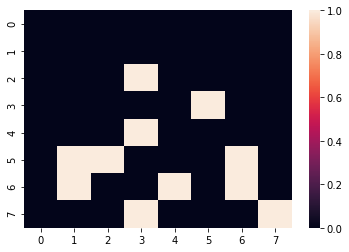

In [55]:
# Random Start Monte Carlo Q learning
env = gym.make('FrozenLake8x8-v0', is_slippery=False)
# env = gym.make('FrozenLake-v0', is_slippery=False)
# env = gym.make('FrozenLake8x8-v0', is_slippery=True)
# env = gym.make('FrozenLake-v0', is_slippery=True)
env_map = env.env.desc
term_state_flag = np.array([[s for s in row] for row in env_map])
map_shape = term_state_flag.shape
term_state_flag = np.isin(term_state_flag, [b'H', b'G']).reshape(-1)
possible_starts = np.array(range(len(term_state_flag)))[np.logical_not(term_state_flag)]
absorbing_states = np.array(range(len(term_state_flag)))[term_state_flag]
sn.heatmap(term_state_flag.reshape(map_shape))

In [74]:
# MODEL INPUTS

# State action space dims
n_actions = env.action_space.n
n_states = env.observation_space.n
qshape = (n_states, n_actions)
actions=list(range(n_actions))

# Tamper reward?
change_reward = False
r_goal = 10
r_fail = -10
r_standard = -0.1
# Exploring Strarts? 
random_starts = False

# algorithm parameters
num_episodes = 1000000
print_episode_num = int(num_episodes/10)
max_steps = 100
gamma = 0.9
epsilon = 0.8

In [75]:
# Initialise the policy (random policy)
Q = np.zeros(qshape)
p = get_p_from_Q(Q)
C = np.zeros(Q.shape)
Returns = np.zeros(Q.shape)

# storing lists
exploring_starts = []
total_episode_reward = []

for episode in range(num_episodes):
    
    # printing
    if episode%print_episode_num == 0: 
        print(">> episode %d" % episode)
    env.reset()
    done = False
    
    #Return
    G = 0
    # Weight
    W = 1
    # steps counter
    steps = 0
    
    # log states, actions and reward as tuples for each trace
    trace = []
    rewards = []
    
    # pick a random state as the starting state
    # starting state shouldn't be a terminal (or absorbing)
    if random_starts:
        obs = possible_starts[np.random.randint(len(possible_starts))]
        exploring_starts.append(obs)
        env.env.s = obs
    else:
        obs = env.env.s
    
    # behavioural policy (epsilon-greedy policy from target policy p to ensure b covers p)
    b = epsilon_greedy(p, epsilon)

    # get trace
    # stop when a terminal state is reached or when the max steps per trace are reached
    while (not done) & (steps < max_steps):
        
        # picking actions
        action = np.random.choice(actions, p=b[obs])
        
        # interact with the environment
        new_obs, reward, done, _= env.step(int(action))
        
        # change the reward to speed up learning
        if change_reward:
            if reward == 1:
                reward = r_goal
            elif reward==0 and done:
                reward = r_fail
            else:
                reward = r_move
        
        # Store state, action and reward
        trace.append((obs, action))
        rewards.append(reward)
        
        # move state
        obs = new_obs
        
        # steps counter
        steps += 1
    
    # at the end of trace
    total_episode_reward.append(sum(rewards))
    
    for step in reversed(range(len(trace))):
        # state action pair
        sa = trace[step]
        
        # make sure this is the first visit
        if sa not in trace[:step]:
            # make calculation for G more efficient
            G = sum([rewards[step:][i]*(gamma**i)
                                         for i in range(len(rewards[step:]))])
            C[sa] += W
            Q[sa] = Q[sa] + W*(G-Q[sa])/C[sa]
            
            # update the policy
            p = get_p_from_Q(Q)
            
            # if this state action pair is not in in the target policy - break the loop
            if p[sa]!=1: 
                break
            
            # update the weight
            W = W*(p[sa]/b[sa]) # equivalent to W*(1/b[sa]) if p is deterministic

>> episode 0
>> episode 100000
>> episode 200000
>> episode 300000
>> episode 400000
>> episode 500000
>> episode 600000
>> episode 700000
>> episode 800000
>> episode 900000


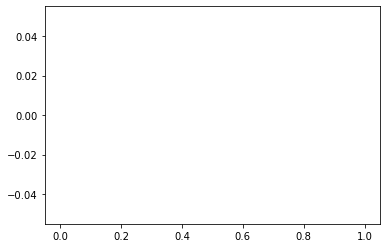

In [76]:
# sanity check for exploring starts
plot = plt.hist(exploring_starts, bins=n_states)

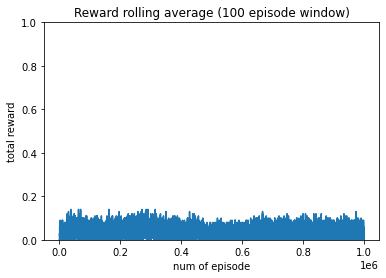

In [77]:
reward_rolling_average = pd.DataFrame()
N = 100
reward_rolling_average['episode reward'] = total_episode_reward
reward_rolling_average['episode reward rolling average (%d)'%N] = (reward_rolling_average.
                                                                   rolling(window=N).
                                                                   mean())

plt.plot(reward_rolling_average['episode reward rolling average (%d)'%N])
plt.title("Reward rolling average (%d episode window)" % N)
plt.xlabel("num of episode")
plt.ylabel("total reward")

if change_reward:
    pass
else:
    plt.ylim((0, 1))

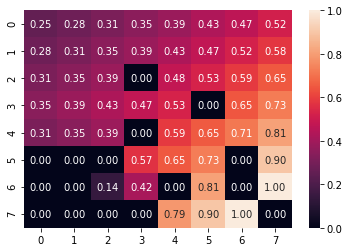

In [78]:
sn.heatmap(np.max(Q, axis=1).reshape(map_shape), annot=True, fmt="0.2f")

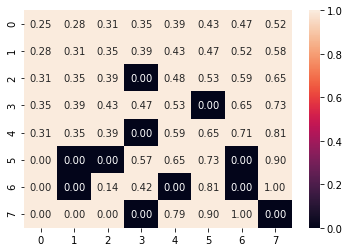

In [79]:
sn.heatmap(np.logical_not(term_state_flag).reshape(map_shape), annot=np.max(Q, axis=1).reshape(map_shape), fmt="0.2f")

### Testing

In [146]:
p = np.random.randint(low=0, high=n_actions, size=n_states)

In [8]:
# Creating the tie breaker

# Dummy matrix with one clear max
M = np.ones((3,4))
M[0, 0] = 2
M[1, 2] = 3
M[1, 1] = 3
M[2, 2] = 4

# change dims to make sure it broadcasts
p = []
m = np.max(M, axis=1).reshape(M.shape[0], 1)
for row in range(M.shape[0]):
    p.append(np.random.choice(np.argwhere(M[row]==m[row]).flatten()))
print(M)
print(p)
# Need argmax


[[2. 1. 1. 1.]
 [1. 3. 3. 1.]
 [1. 1. 4. 1.]]
[0, 1, 2]


In [28]:
print(epsilon_greedy(get_p_from_Q(M, single_action_in_ties=True), 0.4))

[[0.7 0.1 0.1 0.1]
 [0.1 0.1 0.7 0.1]
 [0.1 0.1 0.7 0.1]]


In [25]:
(M == 1)*0.5

array([[0. , 0.5, 0.5, 0.5],
       [0.5, 0. , 0. , 0.5],
       [0.5, 0.5, 0. , 0.5]])

In [54]:
M[(1,1)]

3.0

In [16]:
print(p)

[0, 1, 2]


In [4]:
# Define an abstract class for all Tabular RL algorithms
class TabularRL(object):
    """
    Abstract class definition
    """
    def __init__(self):
        super().__init__()

    def learn(self):
        raise NotImplementedError('This is an abstract method.')

In [ ]:
custom_map = [
    'SFFFF',
    'HHHHF',
    'HHHHF',
    'HHHHF',
    'HHHHG'
]

custom_map = [
    'SFFFF',
    'FFFFF',
    'FHFFF',
    'FFFFF',
    'FFFFG'
]